In [11]:
import os, sys
import traceback
from Module.allo_chain import *
from Module.count import *
from Module.denoise import *
from Module.network import *
from Module.IO_stat import *

plt.style.use('classic')
%matplotlib inline

In [12]:
def data_list(path):
    data_load = []
    for i in os.listdir(path):
        j = i.split('.')
        if j[-1] == 'txt':
            data_load.append(i)
    return data_load

In [13]:
data_path = './data' #The path of 'data' folder

Text_path = data_path + '/Text/'                   #put your text here
#----------------------------------------------------------------------
Ndom_path = data_path + '/N_dom/'                  #the output folder of N-dom distribution plot
Chain_path = data_path + '/Chain/'                 #the output folder of chain-rank plot
Allo_path = data_path + '/Allocation/'             #the output folder of allocation-rank plot
RRD_path = data_path + '/RRD/'                     #the output folder of RRD plot
FRD_path = data_path + '/FRD/'                     #the output folder of FRD plot
Geo_path = data_path + '/Geometric seq/'           #the output folder of geometric sequence plot
SC_path = data_path + '/SC/'                       #the output document of rg plot and SC value
fitting_path = data_path + '/fitting/'             #the output document of scaling lines fitting
net_block_path = data_path + '/network block/'     #the output document of network analysis of protein
net_compo_path = data_path + '/network component/' #the output document of network analysis of domain
para_path = data_path + '/parameter/'              #the output document of GLC parameters

#----------------------------------------------------------------------
Big_path = data_path + '/Statistical result/'      #the output folder of all statistical data in execl


data_load = data_list(Text_path)
Text_load = [Text_path + i for i in data_load]
for i in data_load:
    print(i)

zebrafish.txt
mouse.txt


In [14]:
#encode = "UTF-16" #(1)
encode = "UTF-8"   #(2)

def main():
    error_list = []
    #-------------------check if folders exist-----------------------------
    PATH = [Ndom_path, Chain_path, Allo_path, RRD_path, FRD_path, Geo_path, SC_path,
            fitting_path, net_block_path, net_compo_path, para_path, Big_path]
    for P in PATH:
        try:           
            os.makedirs(P)  #create the folder
        except:
            print('***The folder "%s" already exist.' % P)
    #----------------------------------------------------------------------
    for Q in range(len(data_load)):
        try:
            filename = data_load[Q]
            name = filename.split('.txt')[0]
            big, dom, protein, longest = info(Text_load[Q], encode)
            count_allo(protein, dom)
            print('Successfully count allocation and chain!' + '(%s)' % filename)
            write_to_excel(big, protein, dom, Big_path + name)
            #--------------plot N-dom plot
            FORMAT = 'png' #the format of your picture
            density = True
            Path = Ndom_path
            
            N_dom_dist(name, big, longest, density, FORMAT, Path)
            #--------------plot geometric_sequence
            V, H = geometric_sequence(protein, dom)
            max_range = 50 #the number of elements in the sequence you want to know
            x = 'H'
            FORMAT = 'pdf' #the format of your picture
            shift = 'N' #If you don't want to measure shift, just assign shift != 'T'.
            Path = Geo_path
            
            RH = which_plot(name, V, H, x, max_range, shift, FORMAT, Path)
            #--------------plot FRD plot
            FORMAT = 'pdf' #the format of your picture
            #auto positioning when (x_pos, y_pos)=(0, 0)
            x_pos = 0
            y_pos = 0
            Path = FRD_path

            FRD_protein = FRD_plot(name, protein, dom, x_pos, y_pos, FORMAT, Path)
            Zipf = FRD_protein['ab'] #(a, b) of a*x ^-b
            #--------------plot RRD plot
            need_line = 'Y'
            number_of_lines = 4
            Color = '#ff0000'
            FORMAT = 'png' #the format of your picture
            Path = RRD_path

            RRD_coordinate = draw_RRD_plot(big, protein, dom, longest, name, V, H,
                           need_line, number_of_lines, Color, FORMAT, Path)
            #--------------plot allocation-rank plot
            FORMAT = 'png' #the format of your picture
            x_pos = 0 #auto positioning = 0; otherwise change the value you want
            y_pos = 0 #auto positioning = 0; otherwise change the value you want
            Path = Allo_path

            Allo_fit = Allo_plot(name, dom, x_pos, y_pos, FORMAT, Path)
            #--------------plot chain-rank plot
            FORMAT = 'png' #the format of your picture
            x_pos = 0 #auto positioning = 0; otherwise change the value you want
            y_pos = 0 #auto positioning = 0; otherwise change the value you want
            Path = Chain_path

            Chain_fit = Chain_plot(name, protein, x_pos, y_pos, FORMAT, Path)
            #--------------calculate SC and fitting scaling lines
            FORMAT = 'pdf' #the format of your picture
            L = 4
            toler = 50
            num_window = 101
            num_section = 2
            delta = 0.15
            percent = 0.05

            g, glu = plot_g(L, V, H, big, name, longest, toler, num_window, num_section, delta, percent)
            Rg = rg(name, g, FORMAT, SC_path)
            
            fit_para_best = fit_with_cut(glu, Rg[0], V, H, Zipf, name, FORMAT, fitting_path)
            #--------------Network analysis
            graph_protein, graph_dom = build_edge(RRD_coordinate)
            G_protein, cluster_protein, protein_degree_sequence = graph_protein[0], graph_protein[1], graph_protein[2]
            G_dom, cluster_dom, dom_degree_sequence = graph_dom[0], graph_dom[1], graph_dom[2]            
            FORMAT = 'pdf'
            
            Path = net_block_path
            plot_degree_block(name, protein_degree_sequence, FORMAT, Path)
            
            Path = net_compo_path
            degree_component = plot_degree_compo(name, dom_degree_sequence, FORMAT, Path)
            #--------------Record all GLC parameters and RRD points
            data_set = {}
            coordinate_set = {}
            
            data_set['FRD_protein'] = FRD_protein
            coordinate_set['RRD_coordinate'] = RRD_coordinate
            data_set['Allo_fit'] = Allo_fit
            data_set['Chain_fit'] = Chain_fit
            coordinate_set['glu'] = glu
            data_set['Rg'] = Rg
            data_set['fit_para_best'] = fit_para_best
            data_set['degree_component'] = degree_component

            #save para_ (GLC paras) and coor_ (RRD points)
            Path = para_path
            para_filename = 'para_' + filename
            save_parameters(para_filename, data_set, Path)            
            coor_filename = 'coor_' + filename
            save_parameters(coor_filename, coordinate_set, Path)
            
            print('Successfully run all!' + '(%s)' % filename)
        #--------------add filename to error_list when error      
        except Exception as exc:
            traceback.print_exc()
            error_list.append(data_load[Q])
            print('')
    if error_list != []:
        print('The following file get error when running:')
        for i in error_list:
            print(i)

***The folder "./data/N_dom/" already exist.
***The folder "./data/Chain/" already exist.
***The folder "./data/Allocation/" already exist.
***The folder "./data/RRD/" already exist.
***The folder "./data/FRD/" already exist.
***The folder "./data/Geometric seq/" already exist.
***The folder "./data/SC/" already exist.
***The folder "./data/fitting/" already exist.
***The folder "./data/network block/" already exist.
***The folder "./data/network component/" already exist.
***The folder "./data/parameter/" already exist.
***The folder "./data/Statistical result/" already exist.
read file successfully!
Successfully count protein freqency!(./data/Text/zebrafish.txt)
Successfully count dom freqency!
Successfully build data frames!
Successfully count allocation and chain!(zebrafish.txt)


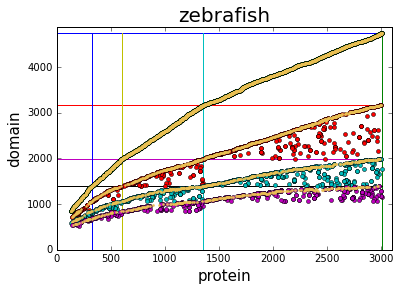

fitting range = [751, 3006]
Successfully run all!(zebrafish.txt)
read file successfully!
Successfully count protein freqency!(./data/Text/mouse.txt)
Successfully count dom freqency!
Successfully build data frames!
Successfully count allocation and chain!(mouse.txt)


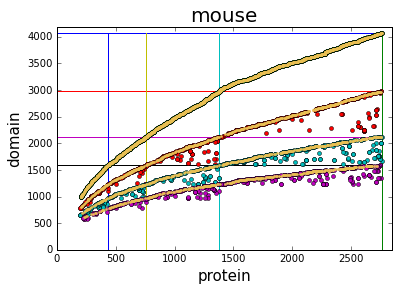

fitting range = [689, 2758]
Successfully run all!(mouse.txt)


In [15]:
main()